In [157]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness, RandomZoom, RandomTranslation

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# import pre-trained model
# from keras.applications.vgg16 import VGG16

# include only those gestures
# CONDITIONS = ['like', 'dislike', 'stop', 'rock', 'peace'] # like/dislike 
# CONDITIONS = ['like', 'dislike', 'stop'] 
CONDITIONS = ['like', 'peace', 'stop']
# CONDITIONS = ['like', 'rock', 'peace']
# CONDITIONS = ['rock', 'peace', 'stop']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

## helper function to load and parse annotations

In [158]:
# relative path to the dataset -> change as needed
PATH = "../gesture_dataset_sample/"

In [159]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'{PATH}_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

In [144]:
# pretty-print first element
# print(json.dumps(annotations['like']['00ae4da4-9462-4804-ab99-5d2e409cd4b2'], indent=2))

## helper function to pre-process images (color channel conversion and resizing)

In [160]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [161]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(f'{PATH}/{condition}')):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{PATH}/{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

## let's have a look at one of the images

In [162]:
label_names

['like', 'no_gesture', 'peace', 'stop']

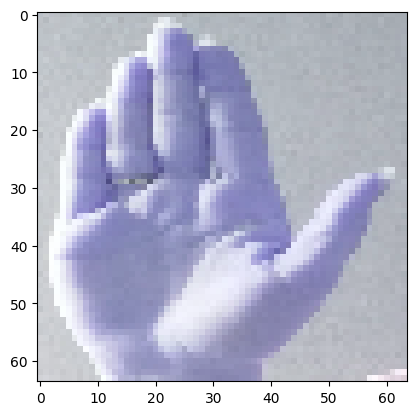

In [163]:
plt.imshow(random.sample(images, 1)[0])

## split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [164]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

776
195
776
195


## transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [165]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(776, 64, 64, 3) (195, 64, 64, 3) (776, 4) (195, 4)


In [166]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'leaky_relu'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
# model.add(RandomContrast(0.1))
model.add(RandomContrast(0.2))
# model.add(RandomTranslation(-0.2, 0.2))
## #model.add(RandomBrightness(0.1))
## #model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

c:\Users\Leonie\Documents\Uni_Regensburg\SS2024\ITT\assignments\assignment-5-cnn-LeS-crypto\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## now, we can train the model using the fit() function
## this will take a while

In [167]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.2319 - loss: 1.4065 - val_accuracy: 0.2513 - val_loss: 1.4338 - learning_rate: 0.0010
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3035 - loss: 1.3830 - val_accuracy: 0.3179 - val_loss: 1.3467 - learning_rate: 0.0010
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3960 - loss: 1.3027 - val_accuracy: 0.4308 - val_loss: 1.1849 - learning_rate: 0.0010
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5521 - loss: 1.0387 - val_accuracy: 0.6000 - val_loss: 0.8577 - learning_rate: 0.0010
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6561 - loss: 0.8223 - val_accuracy: 0.8103 - val_loss: 0.4745 - learning_rate: 0.0010
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7777 - loss: 0.5768 - val_accuracy: 0.7128 - val_loss: 0.6913 - learning_rate: 0.0010
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8138 - loss: 0.4873 - val_acc

In [168]:
# let's have a look at our model
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_6 (RandomFlip)      │ (8, 64, 64, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_6               │ (8, 64, 64, 3)         │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (8, 64, 64, 64)        │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (8, 16, 16, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (8, 16, 16, 32)        │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (8, 6, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (8, 6, 6, 32)          │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (8, 3, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (8, 3, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (8, 288)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (8, 64)                │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (8, 64)                │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (8, 4)                 │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,038 (1.13 MB)

 Trainable params: 99,012 (386.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 198,026 (773.54 KB)

## Plot accuracy and loss of the training process

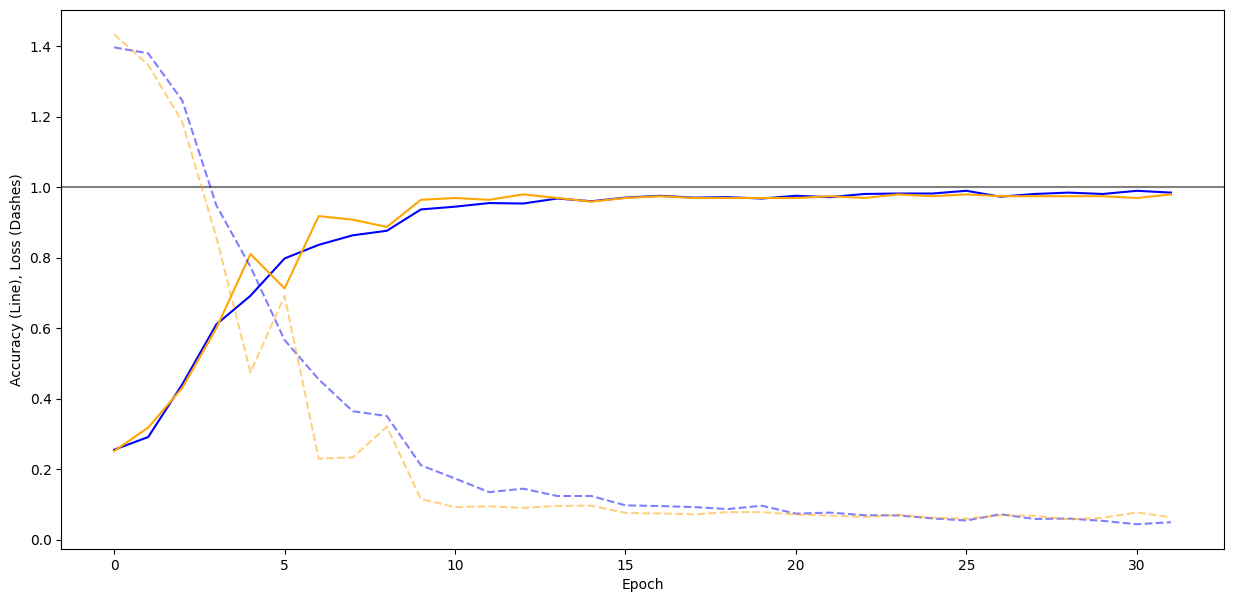

In [169]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

## saving the model

the function will create a directory for your model and save structure and weights in there

sometimes you will see the .h5 format being used - even though this is a bit faster and needs less space, it comes with its limitations and isn't used that much any more

In [170]:
model.save(f'gesture_recognition_{len(CONDITIONS)}.keras')
# model.save(model_file)

# and this is how you load the model
# model = keras.models.load_model("gesture_recognition")

## visualize classification results with a confusion matrix

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
inference time = 0.2578284740447998 sec
probabilities [0 3 0 0 0 3 3 1 0 2 1 2 0 0 1 0 3 2 2 0 0 3 0 2 2 0 1 3 3 2 3 2 1 1 0 2 0
 0 1 3 0 2 0 0 2 2 0 3 3 3 1 0 3 3 2 2 3 1 0 0 3 2 3 0 3 1 1 3 3 0 0 3 3 2
 0 0 1 0 2 2 2 3 0 0 1 3 3 0 0 1 3 2 2 2 3 2 3 0 3 0 3 3 1 0 1 0 3 1 3 1 1
 0 2 1 1 2 1 3 1 3 2 0 0 0 3 2 3 1 1 2 0 2 2 3 0 1 3 2 0 0 2 2 2 1 2 1 1 2
 1 2 2 0 2 3 2 3 2 2 3 3 3 2 0 0 1 2 3 3 0 1 3 1 0 2 2 1 2 3 1 2 1 1 1 1 2
 0 2 3 1 2 3 2 2 0 0]
accuracy_score = 0.9794871794871794


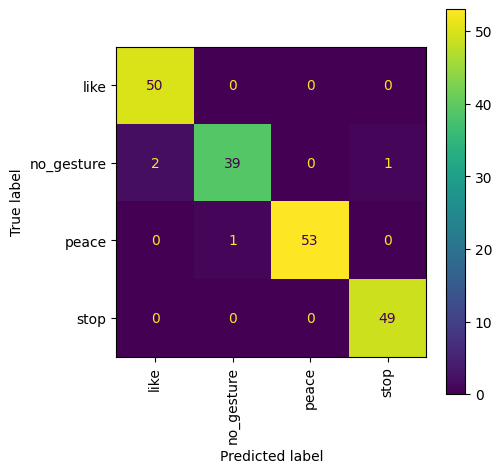

In [171]:
import time
# let the model make predictions for our training data

start = time.time() # measure time
y_predictions = model.predict(X_test)
end = time.time()
print("inference time =", (end-start), "sec") # time in seconds


# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# get the accuracy score
acc_score = accuracy_score(y_test, y_predictions)
print("accuracy_score =", acc_score)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(5, 5))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass